[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldomunaretto/immune_deep_learning/blob/main/notebooks/03_RNN/15_RNN.ipynb)

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [47]:
import tensorflow as tf

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Embedding, Bidirectional, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import set_random_seed
from keras.datasets import imdb

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

set_random_seed(0)

In [4]:
def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [5]:
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


For transforming an id-sequence to a phrase use get_words

In [7]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i, '<UNK>') for i in sentence])


get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# MLP model

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [10]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [11]:
def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [12]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

In [13]:
x_train[0]

array([0.        , 0.00458716, 0.02752294, ..., 0.        , 0.        ,
       0.        ])

## Define and train a model
Define, compile and fit your sequential model

In [16]:
num_words

10003

In [17]:
model = Sequential(
    [
        Input(shape=(num_words,)),
        Dense(10, activation="sigmoid"),
        Dropout(0.1),
        Dense(10, activation="sigmoid"),
        Dropout(0.1),
        Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │         100,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,161 (391.25 KB)

 Trainable params: 100,161 (391.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
history = model.fit(x_train, y_train, epochs=25, validation_split=0.2)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5071 - loss: 0.6997 - val_accuracy: 0.6170 - val_loss: 0.6922
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5148 - loss: 0.6974 - val_accuracy: 0.7732 - val_loss: 0.6907
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5272 - loss: 0.6946 - val_accuracy: 0.7730 - val_loss: 0.6872
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5503 - loss: 0.6887 - val_accuracy: 0.7742 - val_loss: 0.6790
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5811 - loss: 0.6798 - val_accuracy: 0.7788 - val_loss: 0.6609
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6229 - loss: 0.6618 - val_accuracy: 0.7870 - val_loss: 0.6241
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6601 - loss: 0.6295 - val_accuracy: 0.7962 - val_loss: 0.5736
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6914 - loss: 0.5905 - val_accuracy: 0.

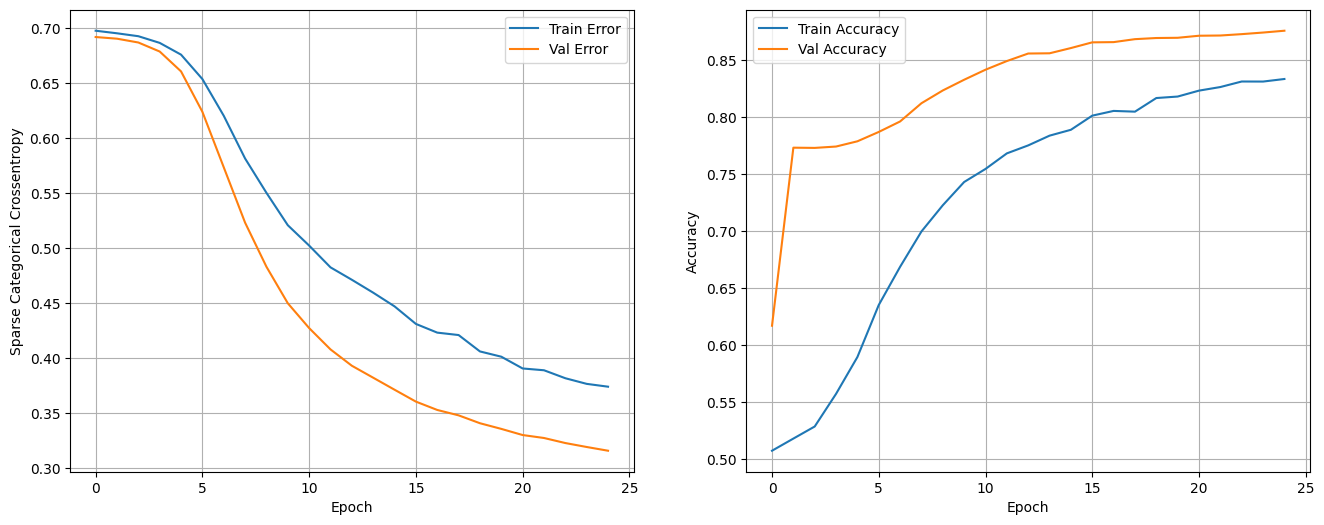

In [21]:
show_loss_accuracy_evolution(history)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [22]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8709 - loss: 0.3238
Test Loss: 0.3241058886051178
Test Accuracy: 0.8708000183105469


### Making predictioins with new data

In [23]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant']

sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


array([[0.0172],
       [0.9981],
       [0.3659]], dtype=float32)

# RNN model

Lets use a recurrent neural network and compare results


### Simple RNN model

There are three built-in RNN layers in Keras:

1. [`SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In sequence classification we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [25]:
# dims of input: [batch, tokens, embedding_dim]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, tokens, embedding_dim): ', inputs.shape)
lstm = LSTM(units=2)
output = lstm(inputs)
print('1. return_state=False output shape: ',output.shape)
lstm = LSTM(units=2, return_sequences=True)
output = lstm(inputs)
print('2. return_state=True output shape: ',output.shape)

input dim (batch, tokens, embedding_dim):  (32, 10, 4)
1. return_state=False output shape:  (32, 2)
2. return_state=True output shape:  (32, 10, 2)


### Loading Data

In [26]:
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
'''size = 15000
(train_data, train_labels), (test_data, test_labels) = (
    (train_data[:size], train_labels[:size]), (test_data[:size], test_labels[:size]))
'''
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

print(train_data.shape, test_data.shape)

(25000,) (25000,)


### Create the RNN model

For the input of the first rnn layer we need a tensor of `(timesteps, features)` or `(batchsize, timesteps, features)`. We have a matrix of sentences of `(train_size, max_len)`. Every sentence is a  `max_len`, we need to convert it to a sentence of one-hot vectors of dim `(max_len, num_words)`.
For get the one-hot encoding of every sequence we are going to use:

```python
layers.Embedding(input_dim=num_words, output_dim=num_words,
  input_length=max_len, embeddings_initializer='identity', trainable=False)
```

This layer converts the input tensor `(batch_size, max_len)` to one-hot encoded sequences `(batch_size, max_len, num_words)`





In [27]:
max_len = 100
x_train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [30]:
seq = np.array([[[0, 1, 2, 2, 0]]])
print(seq, seq.shape)
Embedding(input_dim=3,
          output_dim=3,
          embeddings_initializer='identity',
          trainable=False)(seq)

[[[0 1 2 2 0]]] (1, 1, 5)


<tf.Tensor: shape=(1, 1, 5, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]]], dtype=float32)>

### RNN model
Use `SimpleRNN`,  `GRU`,  `LSTM` or `Bidirectional`


In [32]:
model = Sequential(
    [
        Input(shape=(max_len,), name='input'),
        ## one-hot encoding
        Embedding(input_dim=num_words,
                  output_dim=num_words,
                  embeddings_initializer='identity',
                  trainable=False),
        ## recurrent layers
        SimpleRNN(16, return_sequences=False),
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 2003)           │       4,012,009 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 16)                  │          32,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,044,346 (15.43 MB)

 Trainable params: 32,337 (126.32 KB)

 Non-trainable params: 4,012,009 (15.30 MB)

In [33]:
## set the loss and see the results
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)


Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5593 - loss: 0.6822 - val_accuracy: 0.7072 - val_loss: 0.5998
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7409 - loss: 0.5685 - val_accuracy: 0.7564 - val_loss: 0.5209
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8121 - loss: 0.4518 - val_accuracy: 0.7724 - val_loss: 0.4914
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8306 - loss: 0.4134 - val_accuracy: 0.7952 - val_loss: 0.4530
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8441 - loss: 0.3902 - val_accuracy: 0.7836 - val_loss: 0.4804


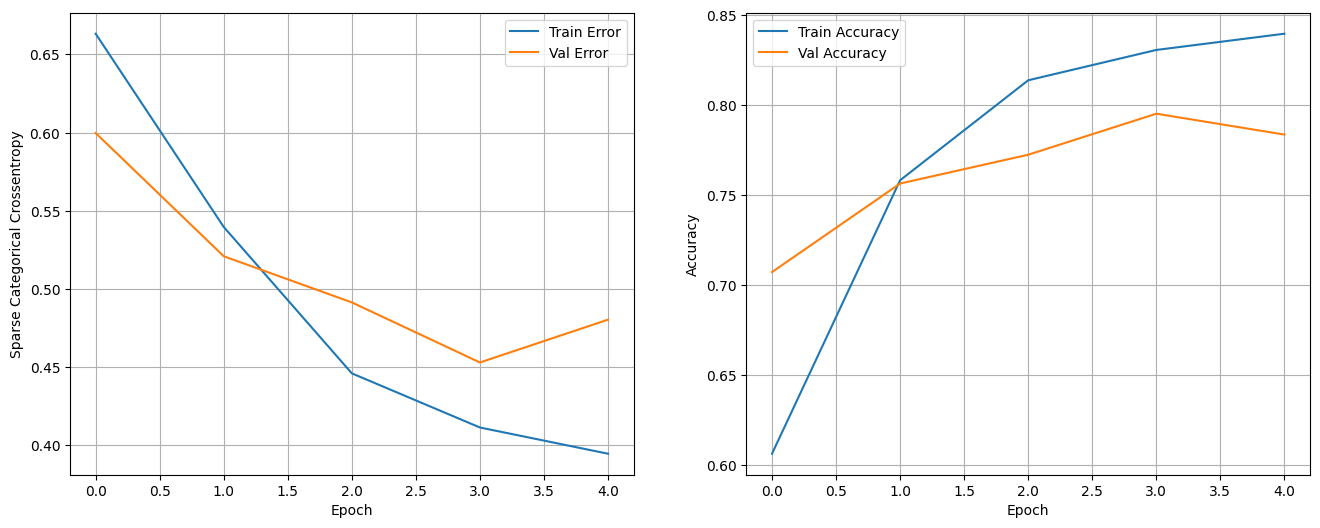

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7747 - loss: 0.4941
Test Loss: 0.49750518798828125
Test Accuracy: 0.7746400237083435


In [34]:
show_loss_accuracy_evolution(history)
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [35]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Predicted : 1, real : 0, lenght: 726
<START> i can imagine what happened for this film to come into being a bunch of studio guys are sitting around <UNK> <UNK> and <UNK> maybe a <UNK> and one of them comes up with the idea that it would be great if they could find a film that would <UNK> the <UNK> <UNK> which at that time was about as far apart as <UNK> <UNK> and <UNK> <UNK> something that both college age <UNK> and their parents would find equally interesting for different reasons perhaps but still a <UNK> is a <UNK> what interested <UNK> <UNK> <UNK> <UNK> and wild sets and costumes what interested their parents <UNK> eye candy a feel good script and <UNK> very well then lost <UNK> the old classic as a musical in color can't miss right it was a <UNK> lost <UNK> by james <UNK> is perhaps less than a classic but not a bad novel in <UNK> terms he <UNK> out a <UNK> society in <UNK> la the <UNK> of the blue moon near <UNK> <UNK> by <UNK> <UNK> <UNK>

#### Making predictions with new data

In [36]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


array([[0.0913],
       [0.897 ],
       [0.8933],
       [0.4278],
       [0.0916],
       [0.0915]], dtype=float32)

In [37]:
1.0*(model.predict(x_pred) > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.]])

### GRU model
Use `GRU`


In [38]:
model = Sequential(
    [
        Input(shape=(max_len,), name='input'),
        ## one-hot encoding
        Embedding(input_dim=num_words,
                  output_dim=num_words,
                  embeddings_initializer='identity',
                  trainable=False),
        ## recurrent layers
        GRU(16, return_sequences=True),
        GRU(16, return_sequences=False),
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 2003)           │       4,012,009 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 16)             │          97,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 16)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,110,666 (15.68 MB)

 Trainable params: 98,657 (385.38 KB)

 Non-trainable params: 4,012,009 (15.30 MB)

In [39]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5117 - loss: 0.6925 - val_accuracy: 0.5712 - val_loss: 0.6838
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6589 - loss: 0.6149 - val_accuracy: 0.7908 - val_loss: 0.4534
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8141 - loss: 0.4146 - val_accuracy: 0.8116 - val_loss: 0.4171
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8355 - loss: 0.3774 - val_accuracy: 0.8136 - val_loss: 0.4128
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8481 - loss: 0.3574 - val_accuracy: 0.8140 - val_loss: 0.4191


In [40]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8039 - loss: 0.4323
Test Loss: 0.43579983711242676
Test Accuracy: 0.8011199831962585


### LSTM model
Use `LSTM`


In [41]:
model = Sequential(
    [
        Input(shape=(max_len,), name='input'),
        ## one-hot encoding
        Embedding(input_dim=num_words,
                  output_dim=num_words,
                  embeddings_initializer='identity',
                  trainable=False),
        ## recurrent layers
        LSTM(16, return_sequences=True),
        LSTM(16, return_sequences=False),
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 2003)           │       4,012,009 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 16)             │         129,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,143,418 (15.81 MB)

 Trainable params: 131,409 (513.32 KB)

 Non-trainable params: 4,012,009 (15.30 MB)

In [42]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5376 - loss: 0.6817 - val_accuracy: 0.7768 - val_loss: 0.4846
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7969 - loss: 0.4460 - val_accuracy: 0.8104 - val_loss: 0.4235
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8378 - loss: 0.3762 - val_accuracy: 0.8080 - val_loss: 0.4285
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8462 - loss: 0.3585 - val_accuracy: 0.8104 - val_loss: 0.4123
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8489 - loss: 0.3528 - val_accuracy: 0.8088 - val_loss: 0.4160


In [43]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7970 - loss: 0.4292
Test Loss: 0.4333950877189636
Test Accuracy: 0.7959200143814087


### Bidirectional model
Use `SimpleRNN`,  `GRU`,  `LSTM` with `Bidirectional`


In [51]:
model = Sequential(
    [
        Input(shape=(max_len,), name='input'),
        ## one-hot encoding
        Embedding(input_dim=num_words,
                  output_dim=num_words,
                  embeddings_initializer='identity',
                  trainable=False),
        ## recurrent layers
        Bidirectional(LSTM(32, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 2003)           │       4,012,009 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 64)             │         521,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,558,122 (17.39 MB)

 Trainable params: 546,113 (2.08 MB)

 Non-trainable params: 4,012,009 (15.30 MB)

In [52]:
## set the loss and see the results
model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

epochs = 50
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.15, epochs=epochs,
                    batch_size=128, callbacks=[early_stopping])

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4918 - loss: 0.6933 - val_accuracy: 0.5360 - val_loss: 0.6926
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5477 - loss: 0.6925 - val_accuracy: 0.5677 - val_loss: 0.6918
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5770 - loss: 0.6915 - val_accuracy: 0.5968 - val_loss: 0.6902
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.6113 - loss: 0.6890 - val_accuracy: 0.6187 - val_loss: 0.6830
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6459 - loss: 0.6651 - val_accuracy: 0.7203 - val_loss: 0.5635
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7474 - loss: 0.5342 - val_accuracy: 0.7725 - val_loss: 0.4922
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7868 - loss: 0.4652 - val_accuracy: 0.7869 - val_loss: 0.4653
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8056 - loss: 0.4336 - val_a

In [53]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8022 - loss: 0.4462
Test Loss: 0.45212504267692566
Test Accuracy: 0.7975999712944031


#### Making predictioins with new data

In [54]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


array([[0.2603],
       [0.9443],
       [0.8488],
       [0.7283],
       [0.347 ],
       [0.3416]], dtype=float32)

In [55]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
Predicted : 1, real : 0, lenght: 51
<START> this movie shows me that americans have no knowledge about the situation in the sad <UNK> brother war please if you want to see <UNK> movies with this theme watch <UNK> and you will see that nobody is bad and nobody is good in this land of tears and <UNK>

Predicted : 0, real : 1, lenght: 304
<START> the house of <UNK> really has nothing new to offer in the way of <UNK> or <UNK> or new twists on an already tired storyline this film was made as a <UNK> sequel to the fairly better made house of <UNK> from a year earlier in house of <UNK> you can see the <UNK> like production values of <UNK> taking their <UNK> on an otherwise <UNK> scary movie <UNK> footage from previous films in the series and then the ending from ghost of <UNK> used as the ending here just makes for an <UNK> flick <UNK> lies the shame of the studio and the producer considering that they had top <UNK> talent and merely wasted <UNK> time 

###  Use a convolutional network instead of a RNN

```python
Conv1D(filters, kernel_size)
```

```python
MaxPool1D(pool_size=2)
```

```python
Flatten()
```

In [56]:
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3


In [57]:
max_len = 100
x_train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [58]:
model = Sequential(
    [
        Input(shape=(max_len,), name='input'),
        ## one-hot encoding
        Embedding(input_dim=num_words,
                  output_dim=num_words,
                  embeddings_initializer='identity',
                  trainable=False),
        ## convolutional layers
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.5),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.5),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 100, 2003)           │       4,012,009 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 32)              │         192,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 49, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 47, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 23, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 23, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 736)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │          23,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,231,050 (16.14 MB)

 Trainable params: 219,041 (855.63 KB)

 Non-trainable params: 4,012,009 (15.30 MB)

In [59]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5079 - loss: 0.6932 - val_accuracy: 0.5912 - val_loss: 0.6761
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6690 - loss: 0.6039 - val_accuracy: 0.7988 - val_loss: 0.4411
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8065 - loss: 0.4208 - val_accuracy: 0.8048 - val_loss: 0.4220
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8425 - loss: 0.3571 - val_accuracy: 0.8160 - val_loss: 0.4061
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8655 - loss: 0.3172 - val_accuracy: 0.8164 - val_loss: 0.4112


In [62]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8162 - loss: 0.4034
Test Loss: 0.4034242331981659
Test Accuracy: 0.81632000207901


In [60]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.1571],
       [0.8681],
       [0.752 ],
       [0.5413],
       [0.2963],
       [0.3391]], dtype=float32)

In [61]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Predicted : 0, real : 1, lenght: 521
<START> i never expected such an old film to be as impressive as this <UNK> western turned out to be the scenes of the <UNK> <UNK> west in their <UNK> <UNK> <UNK> <UNK> and <UNK> river <UNK> indian <UNK> and every manner of <UNK> and <UNK> are <UNK> in their <UNK> <UNK> much of the film was shot <UNK> and the movie has a truly epic feel about it the actors must have <UNK> much the same <UNK> as the original <UNK> did and the results are <UNK> the <UNK> the <UNK> every single detail looks and feels right the characters are simple but believable with a <UNK> story that <UNK> like the <UNK> train to its <UNK> br br john <UNK> is <UNK> and <UNK> in one of his first roles as the <UNK> leading the <UNK> and he does a fine job as the <UNK> young <UNK> he's up against a <UNK> <UNK> of villains including <UNK> <UNK> as a <UNK> <UNK> charles <UNK> as a <UNK> <UNK> and <UNK> power <UNK> as the <UNK> like <UNK> <UNK> <UN